## Lesson 6: Bias and Variance / Hyperparameter and Validation Set
Readings:
- [5.3 Hyperparameters and Validation Sets](https://www.deeplearningbook.org/contents/ml.html) (p. 118)
- [5.4.4 Trading oﬀ Bias and Variance to Minimize Mean Squared Error](https://www.deeplearningbook.org/contents/ml.html) (p. 127)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()

from implements_06.scripts_06 import *

pi = np.pi

Lesson structure:
- Bias and its correspondence to underfitting
- Variance and its correspondence to overfitting
- Hyperparameter optimization
- Validation sets

In [374]:
def format_plot(title, ax=None):
    fontdict={
        'fontsize': 15
    }
    if not ax:
        ax = plt.gca()
    plt.gcf().set_size_inches(8, 6)
    ax.set_xlabel('$X$', fontdict=fontdict)
    ax.set_ylabel('$f(X)$', fontdict=fontdict)
    ax.set_title(title, fontdict=fontdict)

---

Over- and under-fitting are two undesirable extremes in the spectrum of how well a model can [generalize](https://towardsdatascience.com/understand-neural-networks-model-generalization-7baddf1c48ca).
Both results in under-performance relative to optimal behavior.

While we have discussed how to diagnose and remedy these issues, it is also important to understand their underlying causes.
We have explained that overfitting occurs when the model capacity is too high, and underfitting occurs when it is too low.
This happens because of two types of error--**bias** and **variance**--and their relationship to model capacity.

Let's start by creating some sample data and training a regression model.

---

In [10]:
raise NotImplementedError()

NotImplementedError: 

---

We've already seen that by changing the number of polynomial terms, we can increase our **model capacity**, and vice-versa.

We have also discussed that in order to evaluate the performance of our model, we require splitting our data into training and testing subsets.
By calculating how well our model can **generalize** to our test set, we can judge whether we are in an under- or over-fitting regime.

Let's try this

---

In [11]:
raise NotImplementedError()

NotImplementedError: 

---
## Bias

This raises new questions: why do these things happen, and how can we formalize it mathematically?

Underfitting can be explained by **bias**. Bias measures the expected deviation from the true value of the function, independent of the particular sampling.

To illustrate, take the following noisy function:

---

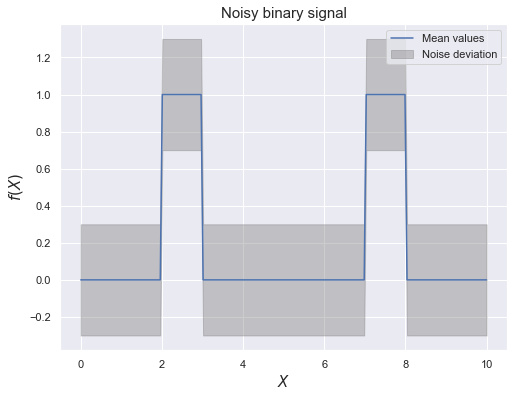

In [375]:
def f(x):
    y_clean = f_noiseless(x)
    y = y_clean + (np.random.randn(len(x))-0.5)*0.6
    return y

def f_noiseless(x):
    y_clean = (((x>=2) & (x<=3)) | ((x>=7) & (x<=8))).astype(np.int32)
    return y_clean
    
X = np.linspace(0,10,200)
Y = f_noiseless(np.linspace(0,10,200))
plt.plot(X, Y, label='Mean values')
plt.fill_between(X, Y-0.3, Y+0.3, color='gray', alpha=0.4, label='Noise deviation')
plt.legend()
format_plot('Noisy binary signal')

---

Let's try to model this distribution using [K-Nearest-Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

Let's sample some data from the distribution, then model it with KNN.

---

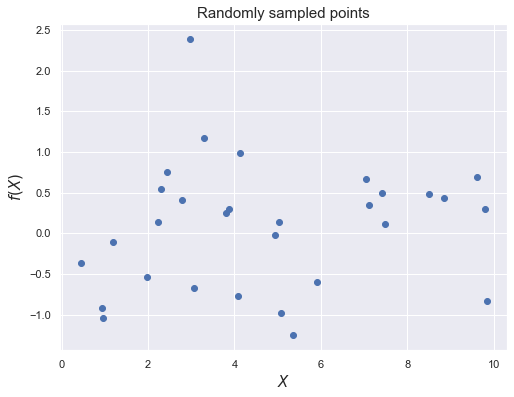

In [297]:
X = np.random.random((30))*10

plt.scatter(X, f(X))
format_plot('Randomly sampled points')

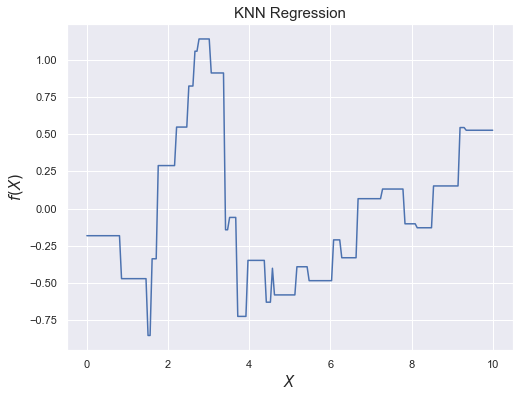

In [298]:
from sklearn import neighbors

# using K=3
KNN_model = neighbors.KNeighborsRegressor(3)
KNN_model.fit(X[...,None], f(X)[...,None])

X_test = np.linspace(0,10,200)
predictions = KNN_model.predict(np.linspace(0,10,200)[...,None])[:,0]
plt.plot(X_test, predictions)
format_plot('KNN Regression')

---

We can plot an error curve for this model as a functino of x:

---

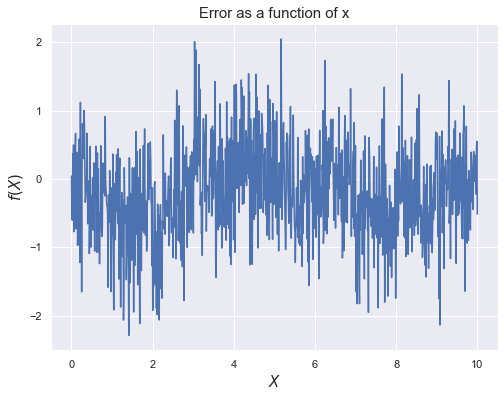

Mean error: -0.21165703553980758 (sampled on 1000 points)


In [302]:
def get_errors(preds, y):
    return preds-y

X_test = np.linspace(0,10,1000)

errors = get_errors(KNN_model.predict(X_test[...,None])[:,0], f(X_test))

plt.plot(X_test, errors)
format_plot('Error as a function of x')
plt.show()

print("Mean error: {} (sampled on {} points)".format(errors.mean(), len(X_test)))

--- 

Wow, that's a very noisy estimator.

To find the bias of this methodology, we need to find the expected errors of this model.

We will approximate these values by taking the average over many different versions of the KNN_model, with different, random training set samples.

---

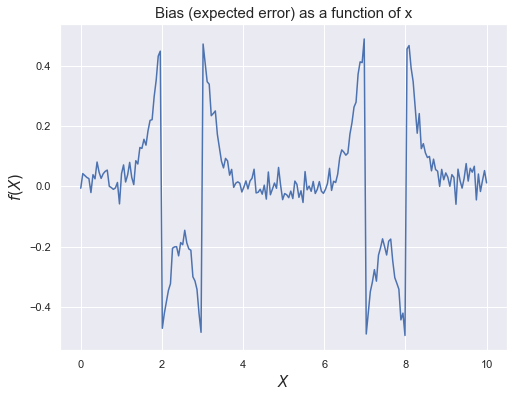

In [318]:
K = 3
X_N = 30 
N = 500

X_test = np.linspace(0,10,200)
errs = []
for _ in range(N):
    X = np.random.random((X_N))*10
    KNN_model = neighbors.KNeighborsRegressor(K)
    KNN_model.fit(X[...,None], f(X)[...,None])

    predictions = KNN_model.predict(np.linspace(0,10,200)[...,None])[:,0]
    errs.append(get_errors(predictions, f(X_test)))
    
errs = np.asarray(errs)
avgs = errs.mean(axis=0)

plt.plot(X_test, avgs)
format_plot('Bias (expected error) as a function of x')
plt.show()

---

Isn't that interesting? Our model consistently underestimates the values around the two peaks, and overestimates the rest. 
In fact, if we add our true values, our predictions seem to take the form of a [bimodal gaussian](https://en.wikipedia.org/wiki/Multimodal_distribution) distribution! [I wonder why...](https://en.wikipedia.org/wiki/Central_limit_theorem)

Feel free to change the model and data parameters to see what happens.

**Bias** is the primary cause of underfitting. We can see a high bias in this particular model because of it's low capacity. In the case of KNN, the capacity is a function of the sample size.
This is because each data point can be thought of as a model parameter, and is used in the prediction calculation. 
For this reason, KNN performs poorly with very large datasets--the distance to each training point must be calculated for prediction.

Try for yourself!

---

---

## Variance
The second primary source of generalization error is **variance**--the deviation from the expected estimator value that any particular sampling will cause.
This can be thought of as an instability to changes in the training points. 
If your model changes drastically with different training samples, then it is likely **overfitting** to the training data.

Let's try calculating this for the KNN model we just used!

---

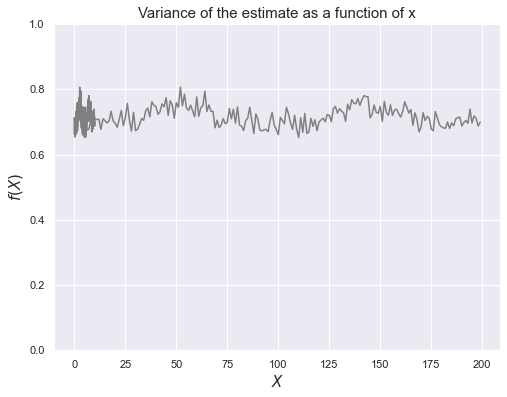

In [341]:
K = 3 
X_N = 30
N = 500

X_test = np.linspace(0,10,200)
errs = []
for _ in range(N):
    X = np.random.random((X_N))*10
    KNN_model = neighbors.KNeighborsRegressor(K)
    KNN_model.fit(X[...,None], f(X)[...,None])

    predictions = KNN_model.predict(np.linspace(0,10,200)[...,None])[:,0]
    errs.append(get_errors(predictions, f(X_test)))
    
errs = np.asarray(errs)
std_err = errs.std(axis=0)

# plt.plot(X_test, avgs)
plt.plot(X_test, std_err, std_err, color='gray')
plt.ylim(0,1)
format_plot('Variance of the estimate as a function of x')
plt.show()

--- 

As we saw, increasing the sample size also increases the model capacity, and so it does not significantly decrease model variance.

---

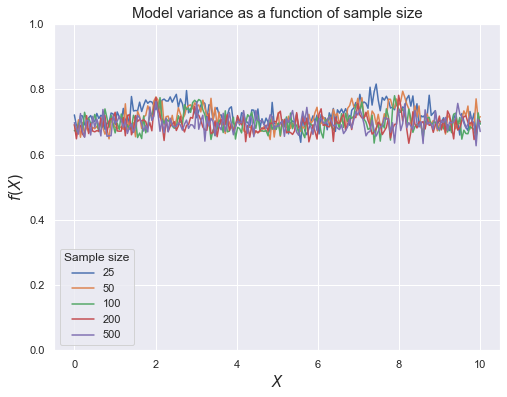

In [345]:
K = 3 
N = 500

for X_N in [25,50,100,200,500]:
    X_test = np.linspace(0,10,200)
    errs = []
    for _ in range(N):
        X = np.random.random((X_N))*10
        KNN_model = neighbors.KNeighborsRegressor(K)
        KNN_model.fit(X[...,None], f(X)[...,None])

        predictions = KNN_model.predict(np.linspace(0,10,200)[...,None])[:,0]
        errs.append(get_errors(predictions, f(X_test)))
    
    errs = np.asarray(errs)
    std_err = errs.std(axis=0)
    plt.plot(X_test, std_err, label=X_N)

format_plot('Model variance as a function of sample size')
plt.legend(title='Sample size')
plt.ylim(0,1)
plt.show()

---

We have one more parameter to play with, **K**. This parameter affects how many nearby points the model uses to make its estimate.
By using more points, we average over a larger number of values which, reduces the effect of noise on our estimate thanks to the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem).

By averaging over more points, we are effectively smoothing our predictions.
This has the effect of **decreasing model capacity** (do you see why?).

*Why not try increasing K to see how it affects the model bias as well?*

---

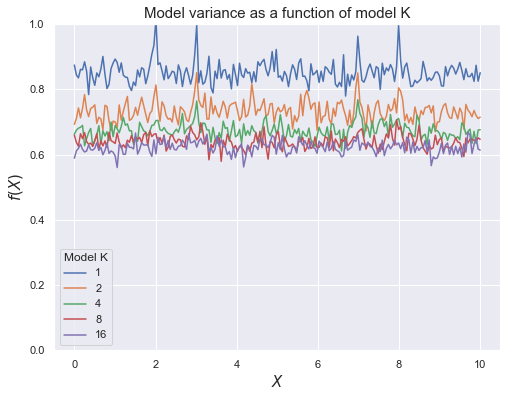

In [352]:
X_N = 200
N = 500

for K in [1,2,4,8,16]:
    X_test = np.linspace(0,10,200)
    errs = []
    for _ in range(N):
        X = np.random.random((X_N))*10
        KNN_model = neighbors.KNeighborsRegressor(K)
        KNN_model.fit(X[...,None], f(X)[...,None])

        predictions = KNN_model.predict(np.linspace(0,10,200)[...,None])[:,0]
        errs.append(get_errors(predictions, f(X_test)))
    
    errs = np.asarray(errs)
    std_err = errs.std(axis=0)
    plt.plot(X_test, std_err, label=K)

format_plot('Model variance as a function of model K')
plt.legend(title='Model K')
plt.ylim(0,1)
plt.show()

---

What do you think our predictions look like as we increase K? 
Give this some thought before running the next portion.

---

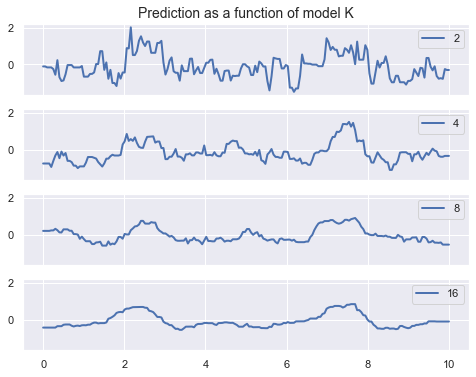

In [407]:
fig, ax = plt.subplots(4, 1, sharex=True, sharey=True)
X_N = 200
X_test = np.linspace(0,10,200)
X = np.random.random((X_N))*10

for i, K in enumerate([2,4,8,16]):
    errs = []
    KNN_model = neighbors.KNeighborsRegressor(K)
    KNN_model.fit(X[...,None], f(X)[...,None])

    predictions = KNN_model.predict(np.linspace(0,10,200)[...,None])[:,0]
    ax[i].plot(X_test, predictions, label=K, lw=2)
    ax[i].legend(loc='upper right')

ax[0].set_title('Prediction as a function of model K', fontdict={'fontsize':14})
fig.set_size_inches(8,6)
plt.show();